We are looking for the coefficients of a convex polynomial
$$p(x, y) = \sum_{i=0}^{2d} c_i x^i y^{2d-i}$$
that maximizes
$$\frac{c_4}{70}.$$
and satisfies
$p(1, 0) = p(0, 1) = 1$, or equivalently $c_0 = c_8 = 1$.

In the following we perform a series of symmetry reduction techniques that will allow us to solve this problem analytically.

## Reducing the number of coefficients in $p$

Note that if $p$ is such a polynomial, then so is $p(-x, -y)$, so we
can assume that $p$ is even (i.e., $c_i = 0$ for $i=1,3,5,7$). Furthermore, if $p$ is a solution, so is
$p(y, x)$, so we can assume that $p$ is symmetric (i.e., $c_i = c_{8-i}$. All in all, without
loss of generality we assume

$$p(x, y) = x^8 + y^8 +  \alpha x^4y^4 + \beta (x^2y^6 + x^6y^2) \text{ for some $\alpha, \beta \in \mathbb R$}.$$


In [193]:
%display latex
R.<a, b, x,y,u,v> = QQ['a,b,x,y,u,v']
vars = [x,y,u,v]

q = x^8 + y^8 + a*x^4*y^4 + b*(x^2*y^6 + x^6*y^2)
q

b*x^6*y^2 + a*x^4*y^4 + b*x^2*y^6 + x^8 + y^8


## Formulating the problem as an SDP
Because of Theorem 3.6, imposing the condition on the convexity of $p$ we can formulated as a search problem for an $8 \times 8$ positive semidefinite matrix $Q$ that satisfies
 $${\mathbf u}^T\nabla^2q({\mathbf x}){\mathbf u} = z^TQz \quad \forall {\mathbf x},{\mathbf u} \in \mathbb R^2$$
 where
$$z^T({\mathbf x}, {\mathbf u}) = (u x^{2d}, ux^{2d-1}y, \ldots, v y^{2d}, v x^{2d}, v x^{2d-1}y, \ldots, v y^{2d}).$$

Once we have $Q$, we can recover the polynomial $q$ via Euler's identity as follows:

$$q(\mathbf x) = \frac1{8 \cdot 7} z(\mathbf x, \mathbf x)^T Q z(\mathbf x, \mathbf x)$$


Therefore, the objective function ca be written exclusively in terms of the matrix $Q$, and we can rewrite our optimization problem (*) completely in terms of the  matrix $Q$ as follows:

$$\max_{Q \succeq 0} Q \text{ s.t. } Q \in \mathcal L$$
where $\mathcal L$ is the following linear space
$$\{Q \; | \; \exists q = x^8 + y^8 +  \alpha x^4y^4 + \beta (x^2y^6 + x^6y^2) \text{ s.t. } {\mathbf u}^T\nabla^2q({\mathbf x}){\mathbf u} = z^TQz.\}$$

In [194]:
def symb_matrix(N, base_name='Q_%d%d', sym=False):
    var_swapper = lambda i,j: (i, j)
    if sym:
        var_swapper = lambda i,j: (min(i,j), max(i,j))
        
    Q_varnames = ','.join([base_name % var_swapper( i,j) for (i,j) in cartesian_product([range(N),range(N)])])
    Q_vars = var(Q_varnames) 
    Q = matrix(SR,N,N,Q_vars)
    
    return Q
Q = symb_matrix(8, 'Q_%d%d', sym=True)
Q

[Q_00 Q_01 Q_02 Q_03 Q_04 Q_05 Q_06 Q_07]
[Q_01 Q_11 Q_12 Q_13 Q_14 Q_15 Q_16 Q_17]
[Q_02 Q_12 Q_22 Q_23 Q_24 Q_25 Q_26 Q_27]
[Q_03 Q_13 Q_23 Q_33 Q_34 Q_35 Q_36 Q_37]
[Q_04 Q_14 Q_24 Q_34 Q_44 Q_45 Q_46 Q_47]
[Q_05 Q_15 Q_25 Q_35 Q_45 Q_55 Q_56 Q_57]
[Q_06 Q_16 Q_26 Q_36 Q_46 Q_56 Q_66 Q_67]
[Q_07 Q_17 Q_27 Q_37 Q_47 Q_57 Q_67 Q_77]

In [195]:
d = 4
z = vector((x^3*u - y^3*v, x*y^2*u - x^2*y*v,
     x^3*u + y^3*v, x*y^2*u + x^2*y*v, 
     x^2*y*u - x*y^2*v, y^3*u - x^3*v,
     x^2*y*u + x*y^2*v, y^3*u + x^3*v))

# hessian of q
Hq = jacobian(jacobian(q, (x, y)), (x, y))
# Q is in L if the following polynomial has all its coefficients equal to 0
diff = z * Q * z - vector([u,v]) * Hq * vector([u, v])

eqn_L = QQ[Q.variables() + (a,b)][x,y,u,v](diff).coefficients()

# the following function gives a description of Q in terms 
# of the smallest number of variables possible

def eliminate_var_matrix(Q, eqn, name, additional_vars=[]):
    def matrix_var(Q, v):
        M = matrix(SR, Q.nrows(), Q.ncols())
        for i in range(Q.nrows()):
            for j in range(Q.ncols()):
                if Q[i,j] == v:
                    M[i, j] = 1
        return M
    all_vars = list(set(sum([list(eqi.variables()) for eqi in eqn], list(Q.variables()))))
    all_vars += additional_vars
    all_vars = map(SR, all_vars)
    eqn += [v - v for v in all_vars]
    #all_vars = Q_vars+c_vars
    #print(Q, all_vars)
    sols = solve(map(lambda eqn_i: SR(eqn_i) == 0, eqn), all_vars)
    assert len(sols) == 1
    sols = sols[0]
    r_F = [(term.rhs(), matrix_var(Q, term.lhs())) for term in sols]
    Fr = sum([ri * Fi for ri, Fi in r_F])
    var_to_sub = sum([list(term.rhs().variables()) for term in sols], [])
    #var_sub = {v: var(name+str(i)) for i,v in enumerate(Fr.variables())}
    var_sub = {v: var(name+str(i)) for i,v in enumerate(var_to_sub)}
    return Fr.subs(var_sub)

Q_L = eliminate_var_matrix(Q, eqn_L, 'w', [a])
Q_L

[                                                           -w79 + 56                                                                  w80                                                                    0                                                                  w74                                                                 -w73                                                   -1/2*w77 - 1/2*w78                                                                 -w70                                                     -w68 - w70 - w72]
[                                                                 w80                                                                  w75                                                                  w69                                                   -2*w65 + w69 - w74                                                                  w77                                              w73 - 1/2*w77 + 1/2*w78                                                                  w68                                                                 -w72]
[                                                                   0                                                                  w69                                                                  w79 6*w59 - 6*w64 + 13*w67 - w71 + 6*w75 - 6*w79 + 13*w80 + 12*w81 + 168                                                                  w70                                                     -w68 - w70 - w72                                                                  w73                                                   -1/2*w77 - 1/2*w78]
[                                                                 w74                                                   -2*w65 + w69 - w74 6*w59 - 6*w64 + 13*w67 - w71 + 6*w75 - 6*w79 + 13*w80 + 12*w81 + 168                                        -2*w67 - 2*w71 - w75 + 12*w81                                                  w68 + 2*w70 + 2*w72                                                                  w72                                                                  w78                                             -w73 + 1/2*w77 - 1/2*w78]
[                                                                -w73                                                                  w77                                                                  w70                                                  w68 + 2*w70 + 2*w72                                                                  w59                                                                  w67                                                           -w69 - w74                                                                  w65]
[                                                  -1/2*w77 - 1/2*w78                                              w73 - 1/2*w77 + 1/2*w78                                                     -w68 - w70 - w72                                                                  w72                                                                  w67                 w59 - 2*w64 + 2*w67 + w75 - w79 + 2*w80 + 2*w81 + 28                                                      w65 - w69 + w74                                                                    0]
[                                                                -w70                                                                  w68                                                                  w73                                                                  w78                                                           -w69 - w74                                                      w65 - w69 + w74   2*w59 - 3*w64 + 4*w67 + 2*w71 + 3*w75 - 3*w79 + 2*w80 + 6*w81 + 84                                                                  w71]
[                                                    -w68 - w70 - w72                                                     

In [210]:
q_from_Q = (z*Q_L*z).subs({u:x, v:y}) / (2*d*(2*d-1))
q_from_Q =  QQ[Q_L.variables()][x,y](q_from_Q)
objective = q_from_Q.coefficient({xi: 4 for xi in q_from_Q.variables()}) / binomial(2*d, d)
objective = objective.base_ring()(objective)
objective

1/70*w81



## Symmetry reduction techniques applied to $Q$

Let $\rho: \mathbb R^4 \mapsto \mathbb R^4$ be any linear transformation of the variables $(x,y,u,v)$ that leaves the coefficient of $x^4y^4$ in $p$ invariant and leaves polynomial $q(x,y,u,v) := {\mathbf u}^T\nabla^2q({\mathbf x}){\mathbf u}$ invariant, i.e.
$$q(x,y,u,v) = q \circ \rho(x,y,u,v).$$
The function $\rho$ naturally acts linearly on the vector $z(\mathbf x, \mathbf y)$. If we call the $8 \times 8$ matrix of this linear operator $M_\rho$, then 

$$Q \in \mathcal L \iff M_\rho^T Q M_\rho \in \mathcal L.$$
 
 
Let $G$ be a group of such transformations $\rho$, then $Q$ is an optimal solution for (*) if and only if

$$Q^* = \frac1{|G|} \sum_{\rho \in G} M_\rho^T Q M_\rho$$

is also a solution. 

We will take $G$ to be the group generated by the following transformations

\begin{align*}
  (x,y,u,v)   & \mapsto   (y,x,v,u)\\
   \cdot \quad & \mapsto  (-x,y,-u,v)\\
   \cdot \quad & \mapsto  (-x,-y,u,v)\\
   \cdot \quad & \mapsto  (-x,y,u,-v).
\end{align*}

The matrix $Q^*$ will have a very structured sparsity pattern.


To make our computations exact, we work over the ring $R := \mathbb Q[x,y,u,v]$ of polynomials in the variables $x,y,u,v$ with rational coefficients.

In [211]:
symmetries =[[y,x,v,u],
             [-x,y,-u,v],
             [-x,-y,u,v],
             [-x,y,u,-v],
             [x, -y, u, -v],
            [x, -y, -u, v]]
symmetries_rho = map(lambda sym_i: matrix(QQ, jacobian(sym_i, vars)), symmetries)
symmetries_rho

[
[0 1 0 0]  [-1  0  0  0]  [-1  0  0  0]  [-1  0  0  0]  [ 1  0  0  0]
[1 0 0 0]  [ 0  1  0  0]  [ 0 -1  0  0]  [ 0  1  0  0]  [ 0 -1  0  0]
[0 0 0 1]  [ 0  0 -1  0]  [ 0  0  1  0]  [ 0  0  1  0]  [ 0  0  1  0]
[0 0 1 0], [ 0  0  0  1], [ 0  0  0  1], [ 0  0  0 -1], [ 0  0  0 -1],

[ 1  0  0  0]
[ 0 -1  0  0]
[ 0  0 -1  0]
[ 0  0  0  1]
]

In [212]:
G = gap.Group(gens)
G = gap.Elements(G).sage()
G = [matrix(QQ, g_elem_i) for g_elem_i in g_elem]
len(G), G

(16,
 [
[-1  0  0  0]  [-1  0  0  0]  [-1  0  0  0]  [-1  0  0  0]
[ 0 -1  0  0]  [ 0 -1  0  0]  [ 0  1  0  0]  [ 0  1  0  0]
[ 0  0 -1  0]  [ 0  0  1  0]  [ 0  0 -1  0]  [ 0  0  1  0]
[ 0  0  0 -1], [ 0  0  0  1], [ 0  0  0  1], [ 0  0  0 -1],

[ 0 -1  0  0]  [ 0 -1  0  0]  [ 0 -1  0  0]  [ 0 -1  0  0]
[-1  0  0  0]  [-1  0  0  0]  [ 1  0  0  0]  [ 1  0  0  0]
[ 0  0  0 -1]  [ 0  0  0  1]  [ 0  0  0 -1]  [ 0  0  0  1]
[ 0  0 -1  0], [ 0  0  1  0], [ 0  0  1  0], [ 0  0 -1  0],

[ 0  1  0  0]  [ 0  1  0  0]  [ 0  1  0  0]  [0 1 0 0]  [ 1  0  0  0]
[-1  0  0  0]  [-1  0  0  0]  [ 1  0  0  0]  [1 0 0 0]  [ 0 -1  0  0]
[ 0  0  0 -1]  [ 0  0  0  1]  [ 0  0  0 -1]  [0 0 0 1]  [ 0  0 -1  0]
[ 0  0  1  0], [ 0  0 -1  0], [ 0  0 -1  0], [0 0 1 0], [ 0  0  0  1],

[ 1  0  0  0]  [ 1  0  0  0]  [1 0 0 0]
[ 0 -1  0  0]  [ 0  1  0  0]  [0 1 0 0]
[ 0  0  1  0]  [ 0  0 -1  0]  [0 0 1 0]
[ 0  0  0 -1], [ 0  0  0 -1], [0 0 0 1]
])

In [213]:
rho_acting_on_z = [z.subs({vi: subi for vi,subi in zip(vars, g*vector(vars))}) for g in G]
rho_acting_on_z

[(x^3*u - y^3*v, x*y^2*u - x^2*y*v, x^3*u + y^3*v, x*y^2*u + x^2*y*v, x^2*y*u - x*y^2*v, y^3*u - x^3*v, x^2*y*u + x*y^2*v, y^3*u + x^3*v),
 (-x^3*u + y^3*v, -x*y^2*u + x^2*y*v, -x^3*u - y^3*v, -x*y^2*u - x^2*y*v, -x^2*y*u + x*y^2*v, -y^3*u + x^3*v, -x^2*y*u - x*y^2*v, -y^3*u - x^3*v),
 (x^3*u - y^3*v, x*y^2*u - x^2*y*v, x^3*u + y^3*v, x*y^2*u + x^2*y*v, -x^2*y*u + x*y^2*v, -y^3*u + x^3*v, -x^2*y*u - x*y^2*v, -y^3*u - x^3*v),
 (-x^3*u + y^3*v, -x*y^2*u + x^2*y*v, -x^3*u - y^3*v, -x*y^2*u - x^2*y*v, x^2*y*u - x*y^2*v, y^3*u - x^3*v, x^2*y*u + x*y^2*v, y^3*u + x^3*v),
 (-x^3*u + y^3*v, -x*y^2*u + x^2*y*v, x^3*u + y^3*v, x*y^2*u + x^2*y*v, -x^2*y*u + x*y^2*v, -y^3*u + x^3*v, x^2*y*u + x*y^2*v, y^3*u + x^3*v),
 (x^3*u - y^3*v, x*y^2*u - x^2*y*v, -x^3*u - y^3*v, -x*y^2*u - x^2*y*v, x^2*y*u - x*y^2*v, y^3*u - x^3*v, -x^2*y*u - x*y^2*v, -y^3*u - x^3*v),
 (-x^3*u + y^3*v, -x*y^2*u + x^2*y*v, x^3*u + y^3*v, x*y^2*u + x^2*y*v, x^2*y*u - x*y^2*v, y^3*u - x^3*v, -x^2*y*u - x*y^2*v, -y^3*u - x^3*v),
 (x^3*u - y^3*v, x*y^2*u - x^2*y*v, -x^3*u - y^3*v, -x*y^2*u - x^2*y*v, -x^2*y*u + x*y^2*v, -y^3*u + x^3*v, x^2*y*u + x*y^2*v, y^3*u + x^3*v),
 (x^3*u - y^3*v, x*y^2*u - x^2*y*v, -x^3*u - y^3*v, -x*y^2*u - x^2*y*v, -x^2*y*u + x*y^2*v, -y^3*u + x^3*v, x^2*y*u + x*y^2*v, y^3*u + x^3*v),
 (-x^3*u + y^3*v, -x*y^2*u + x^2*y*v, x^3*u + y^3*v, x*y^2*u + x^2*y*v, x^2*y*u - x*y^2*v, y^3*u - x^3*v, -x^2*y*u - x*y^2*v, -y^3*u - x^3*v),
 (x^3*u - y^3*v, x*y^2*u - x^2*y*v, -x^3*u - y^3*v, -x*y^2*u - x^2*y*v, x^2*y*u - x*y^2*v, y^3*u - x^3*v, -x^2*y*u - x*y^2*v, -y^3*u - x^3*v),
 (-x^3*u + y^3*v, -x*y^2*u + x^2*y*v, x^3*u + y^3*v, x*y^2*u + x^2*y*v, -x^2*y*u + x*y^2*v, -y^3*u + x^3*v, x^2*y*u + x*y^2*v, y^3*u + x^3*v),
 (-x^3*u + y^3*v, -x*y^2*u + x^2*y*v, -x^3*u - y^3*v, -x*y^2*u - x^2*y*v, x^2*y*u - x*y^2*v, y^3*u - x^3*v, x^2*y*u + x*y^2*v, y^3*u + x^3*v),
 (x^3*u - y^3*v, x*y^2*u - x^2*y*v, x^3*u + y^3*v, x*y^2*u + x^2*y*v, -x^2*y*u + x*y^2*v, -y^3*u + x^3*v, -x^2*y*u - x*y^2*v, -y^3*u - x^3*v),
 (-x^3*u + y^3*v, -x*y^2*u + x^2*y*v, -x^3*u - y^3*v, -x*y^2*u - x^2*y*v, -x^2*y*u + x*y^2*v, -y^3*u + x^3*v, -x^2*y*u - x*y^2*v, -y^3*u - x^3*v),
 (x^3*u - y^3*v, x*y^2*u - x^2*y*v, x^3*u + y^3*v, x*y^2*u + x^2*y*v, x^2*y*u - x*y^2*v, y^3*u - x^3*v, x^2*y*u + x*y^2*v, y^3*u + x^3*v)]

In [214]:
def compute_M_rho(rho_z):
    return matrix(QQ,
      [ [1 if zj == zi else -1 if  zj == -zi else 0 for zi in z]
        for zj in rho_z])
M_rho = map(compute_M_rho, rho_acting_on_z)
M_rho[:2]

[
[1 0 0 0 0 0 0 0]  [-1  0  0  0  0  0  0  0]
[0 1 0 0 0 0 0 0]  [ 0 -1  0  0  0  0  0  0]
[0 0 1 0 0 0 0 0]  [ 0  0 -1  0  0  0  0  0]
[0 0 0 1 0 0 0 0]  [ 0  0  0 -1  0  0  0  0]
[0 0 0 0 1 0 0 0]  [ 0  0  0  0 -1  0  0  0]
[0 0 0 0 0 1 0 0]  [ 0  0  0  0  0 -1  0  0]
[0 0 0 0 0 0 1 0]  [ 0  0  0  0  0  0 -1  0]
[0 0 0 0 0 0 0 1], [ 0  0  0  0  0  0  0 -1]
]

In [285]:
Q_star = sum(M.T *Q_L*M for M in M_rho) / len(M_rho)
[Q_star[i:i+2, i:i+2] for i in range(0, 8, 2)]

[
[-w79 + 56       w80]  [                                                                 w79 6*w59 - 6*w64 + 13*w67 - w71 + 6*w75 - 6*w79 + 13*w80 + 12*w81 + 168]  [                                                 w59                                                  w67]  [2*w59 - 3*w64 + 4*w67 + 2*w71 + 3*w75 - 3*w79 + 2*w80 + 6*w81 + 84                                                                w71]
[      w80       w75], [6*w59 - 6*w64 + 13*w67 - w71 + 6*w75 - 6*w79 + 13*w80 + 12*w81 + 168                                        -2*w67 - 2*w71 - w75 + 12*w81], [                                                 w67 w59 - 2*w64 + 2*w67 + w75 - w79 + 2*w80 + 2*w81 + 28], [                                                               w71                                                                w64]
]

The matrix $Q^*$ has therefore the form
$Q^* = diag(Q_1, Q_2, Q_3, Q_4)$,
where the $Q_i$ are $2 \times 2$ symmetric matrices. $Q^* \succeq 0$ if and only if $Q_1,\ldots,Q_4 \succeq 0$

# Dual 

Let us now derive the dual of the previous problem

In [216]:
#DQ is the dual variable
DQi = [symb_matrix(2, 'D'+str(i)+'_%d%d', sym=True) for i in range(4)]
DQ = block_diagonal_matrix(DQi)
DQ

[D0_00 D0_01|    0     0|    0     0|    0     0]
[D0_01 D0_11|    0     0|    0     0|    0     0]
[-----------+-----------+-----------+-----------]
[    0     0|D1_00 D1_01|    0     0|    0     0]
[    0     0|D1_01 D1_11|    0     0|    0     0]
[-----------+-----------+-----------+-----------]
[    0     0|    0     0|D2_00 D2_01|    0     0]
[    0     0|    0     0|D2_01 D2_11|    0     0]
[-----------+-----------+-----------+-----------]
[    0     0|    0     0|    0     0|D3_00 D3_01]
[    0     0|    0     0|    0     0|D3_01 D3_11]

In [291]:
hessian = lambda pp: jacobian(jacobian(pp, (x,y)), (x,y))
dot = lambda u,v: vector(u) * vector(v)
mdot = lambda A, B: dot(A.list(), B.list())


lagrangian = mdot(DQ, Q_star) + objective
var_primal = Q_star.variables()
var_dual = DQ.variables()
lagrangian = QQ[var_dual][var_primal] (lagrangian)
lagrangian


(12*D1_01 + D2_00 + D2_11 + 2*D3_00)*w59 + (-12*D1_01 - 2*D2_11 - 3*D3_00 + D3_11)*w64 + (26*D1_01 - 2*D1_11 + 2*D2_01 + 2*D2_11 + 4*D3_00)*w67 + (-2*D1_01 - 2*D1_11 + 2*D3_00 + 2*D3_01)*w71 + (D0_11 + 12*D1_01 - D1_11 + D2_11 + 3*D3_00)*w75 + (-D0_00 + D1_00 - 12*D1_01 - D2_11 - 3*D3_00)*w79 + (2*D0_01 + 26*D1_01 + 2*D2_11 + 2*D3_00)*w80 + (24*D1_01 + 12*D1_11 + 2*D2_11 + 6*D3_00 + 1/70)*w81 + 56*D0_00 + 336*D1_01 + 28*D2_11 + 84*D3_00

In [292]:
lagrang_coeffs = jacobian(lagrangian, var_primal)[0]
lagrang_coeffs = list(lagrang_coeffs)
DQ_star = eliminate_var_matrix(DQ, lagrang_coeffs, 'z')
DQ_star

[                                    z17 9/4*z13 + 1/12*z20 + 13/2*z22 + 13/1680                                       0                                       0                                       0                                       0                                       0                                       0]
[9/4*z13 + 1/12*z20 + 13/2*z22 + 13/1680                           7*z22 + 1/140                                       0                                       0                                       0                                       0                                       0                                       0]
[                                      0                                       0                     z17 - 6*z22 - 1/140  -1/4*z13 - 1/12*z20 - 1/2*z22 - 1/1680                                       0                                       0                                       0                                       0]
[                                      0                                       0  -1/4*z13 - 1/12*z20 - 1/2*z22 - 1/1680                                     z22                                       0                                       0                                       0                                       0]
[                                      0                                       0                                       0                                       0                     z13 + 6*z22 + 1/140 5/4*z13 + 1/12*z20 + 15/2*z22 + 13/1680                                       0                                       0]
[                                      0                                       0                                       0                                       0 5/4*z13 + 1/12*z20 + 15/2*z22 + 13/1680                                     z20                                       0                                       0]
[                                      0                                       0                                       0                                       0                                       0                                       0                                     z13  -5/4*z13 - 1/12*z20 + 1/2*z22 - 1/1680]
[                                      0                                       0                                       0                                       0                                       0                                       0  -5/4*z13 - 1/12*z20 + 1/2*z22 - 1/1680                     z20 - 6*z22 - 1/140]

# use KKT conditions to transform the SDP to a system of polynomial equations

In [219]:
R = QQ[DQ_star.variables() + Q_star.variables()]

# KKT equations
KKT_eqn = (DQ_star * Q_star).list()
KKT_eqn = list(set(KKT_eqn))

# ideal generated by the KKT equations
I = map(lambda p: R(p), KKT_eqn)
I = R*I

In [226]:
print("Ideal I has %d equations in %d variables" % (len(I.gens()), len(R.gens())))

Ideal I has 17 equations in 12 variables


In [227]:
# eliminate all variables except those present in the objective function
I_a = I.elimination_ideal([v for v in R.gens() if v not in objective.variables()])
I_a

Ideal (9*w81^14 - 2070*w81^13 + 170888*w81^12 - 5575088*w81^11 + 24286192*w81^10 + 1799298144*w81^9 - 13606662400*w81^8 - 140207761920*w81^7 + 434444465920*w81^6 + 3454598698496*w81^5 - 69628131328*w81^4 - 12362877284352*w81^3 - 5808164827136*w81^2 + 2696323768320*w81) of Multivariate Polynomial Ring in z13, z17, z20, z22, w59, w64, w67, w71, w75, w79, w80, w81 over Rational Field

In [255]:
I_a.gens()

[9*w81^14 - 2070*w81^13 + 170888*w81^12 - 5575088*w81^11 + 24286192*w81^10 + 1799298144*w81^9 - 13606662400*w81^8 - 140207761920*w81^7 + 434444465920*w81^6 + 3454598698496*w81^5 - 69628131328*w81^4 - 12362877284352*w81^3 - 5808164827136*w81^2 + 2696323768320*w81]

In [256]:
factor(I_a.gens()[0])

w81 * (w81 - 70) * (w81 - 38) * (w81 - 14) * (w81 - 6) * (w81 - 2) * (w81 + 2) * (w81 + 14) * (3*w81 + 14) * (3*w81^2 - 164*w81 - 148) * (w81^3 - 66*w81^2 - 340*w81 + 104)

The elimination ideal $I_a$ is generated by one polynomial of degree 14,

$$9*x^14 - 2070*x^13 + 170888*x^12 - 5575088*x^11 + 24286192*x^10 + 1799298144*x^9 - 13606662400*x^8 - 140207761920*x^7 + 434444465920*x^6 + 3454598698496*x^5 - 69628131328*x^4 - 12362877284352*x^3 - 5808164827136*x^2 + 2696323768320*x$$

which factors to 

$$x * (x - 70) * (x - 38) * (x - 14) * (x - 6) * (x - 2) * (x + 2) * (x + 14) * (3*x + 14) * (3*x^2 - 164*x - 148) * (x^3 - 66*x^2 - 340*x + 104)$$

The factor if interest to us is 
$$x^3 - 66\;x^2 - 340\;x + 104.$$


letting $t = x/70$, we get

In [305]:
RDF[y]((x^3 - 66*x^2 - 340*x + 104).subs(x=70*y) / 343000).roots()

[(-0.07246205065830763, 1),
 (0.0041380873389235545, 1),
 (1.0111811061765266, 1)]

In [298]:
66/70

33/35

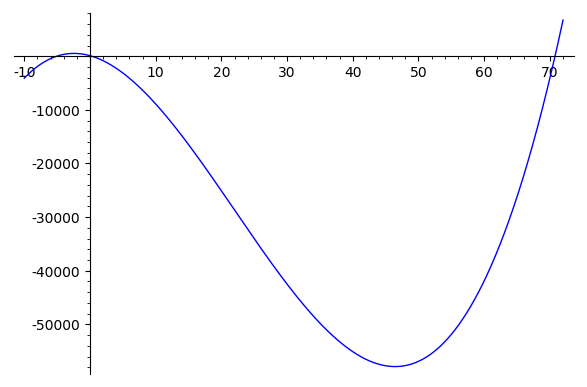

In [284]:
poly = QQ[x](I_a.gens()[0].subs(w81=x)) / 9
#plot([pi for pi,_ in factor(poly)[:]], xmin=-10, xmax=72, ymin=-1e3, ymax=1e2)
plot(factor(poly)[-1][0], xmin=-10, xmax=72)#, ymin=-1e3, ymax=1e2)


In [252]:
roots = matrix.companion(poly).eigenvalues()
roots

[70, 38, 14, 6, 2, 0, -2, -14/3, -14, -0.888013984688967?, 55.55468065135564?, -5.072343546081534?, 0.2896661137246489?, 70.7826774323569?]

In [312]:
map(lambda r: r.radical_expression()/70, roots)

[1,
 19/35,
 1/5,
 3/35,
 1/35,
 0,
 -1/35,
 -1/15,
 -1/5,
 -16/105*sqrt(7) + 41/105,
 16/105*sqrt(7) + 41/105,
 -1/140*(14336/9*I*sqrt(3) + 14336)^(1/3)*(-I*sqrt(3) + 1) - 64/15*(I*sqrt(3) + 1)/(14336/9*I*sqrt(3) + 14336)^(1/3) + 11/35,
 -1/140*(14336/9*I*sqrt(3) + 14336)^(1/3)*(I*sqrt(3) + 1) - 64/15*(-I*sqrt(3) + 1)/(14336/9*I*sqrt(3) + 14336)^(1/3) + 11/35,
 1/70*(14336/9*I*sqrt(3) + 14336)^(1/3) + 128/15/(14336/9*I*sqrt(3) + 14336)^(1/3) + 11/35]